In [16]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # Added for numerical operations

# Load the dataset
df = pd.read_csv(r"C:\Users\paras\Downloads\retail_sales_dataset.csv")

# Display the first few rows of the DataFrame
print(df.head())


   Transaction ID        Date Customer ID  Gender  Age Product Category  \
0               1  2023-11-24     CUST001    Male   34           Beauty   
1               2  2023-02-27     CUST002  Female   26         Clothing   
2               3  2023-01-13     CUST003    Male   50      Electronics   
3               4  2023-05-21     CUST004    Male   37         Clothing   
4               5  2023-05-06     CUST005    Male   30           Beauty   

   Quantity  Price per Unit  Total Amount  
0         3              50           150  
1         2             500          1000  
2         1              30            30  
3         1             500           500  
4         2              50           100  


In [17]:
# Section 2: Data Cleaning and Preprocessing

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract Month and Year
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# --- Outlier Detection and Handling ---
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)].copy()  # Create a copy
    return df_filtered

# Remove outliers from 'Total Amount' - Focus only on total amount for now
numerical_cols = ['Total Amount']  # Adjust this list if needed
for col in numerical_cols:
    df = remove_outliers(df, col)


# Handle missing values (if any) - Imputation with mean for numerical columns
if not df.empty:  # Check if DataFrame is empty after outlier removal
    for col in df.select_dtypes(include=['number']).columns:
        df[col] = df[col].fillna(df[col].mean())  # Corrected fillna
else:
    print("DataFrame is empty after outlier removal. Skipping imputation.")

print(df.head())


   Transaction ID       Date Customer ID  Gender  Age Product Category  \
0               1 2023-11-24     CUST001    Male   34           Beauty   
1               2 2023-02-27     CUST002  Female   26         Clothing   
2               3 2023-01-13     CUST003    Male   50      Electronics   
3               4 2023-05-21     CUST004    Male   37         Clothing   
4               5 2023-05-06     CUST005    Male   30           Beauty   

   Quantity  Price per Unit  Total Amount  Month  Year  
0         3              50           150     11  2023  
1         2             500          1000      2  2023  
2         1              30            30      1  2023  
3         1             500           500      5  2023  
4         2              50           100      5  2023  


In [18]:
# --- Descriptive Statistics ---
print("Descriptive Statistics:")
print(df.describe())


Descriptive Statistics:
       Transaction ID                           Date         Age     Quantity  \
count     1000.000000                           1000  1000.00000  1000.000000   
mean       500.500000  2023-07-03 00:25:55.200000256    41.39200     2.514000   
min          1.000000            2023-01-01 00:00:00    18.00000     1.000000   
25%        250.750000            2023-04-08 00:00:00    29.00000     1.000000   
50%        500.500000            2023-06-29 12:00:00    42.00000     3.000000   
75%        750.250000            2023-10-04 00:00:00    53.00000     4.000000   
max       1000.000000            2024-01-01 00:00:00    64.00000     4.000000   
std        288.819436                            NaN    13.68143     1.132734   

       Price per Unit  Total Amount        Month         Year  
count     1000.000000   1000.000000  1000.000000  1000.000000  
mean       179.890000    456.000000     6.549000  2023.002000  
min         25.000000     25.000000     1.000000  2023

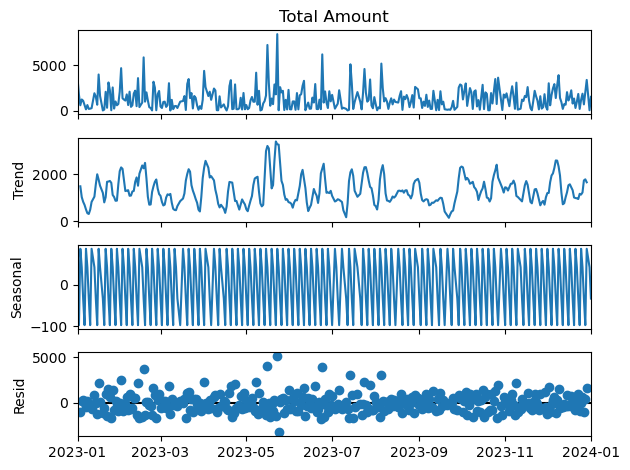

In [19]:
# --- Time Series Analysis ---
# Aggregate sales by month
monthly_sales = df.groupby('Date')['Total Amount'].sum()

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
try:
    decomposition = seasonal_decompose(monthly_sales, model='additive', period=4)
    fig = decomposition.plot()
    plt.show()
except Exception as e:
    print(f"Time Series Decomposition Failed: {e}")

# Calculate moving averages
df['Moving Average'] = df['Total Amount'].rolling(window=4).mean()


In [20]:
# --- Customer and Product Analysis ---
# Sales by Gender
gender_sales = df.groupby('Gender')['Total Amount'].sum()

# Sales by Product Category
category_sales = df.groupby('Product Category')['Total Amount'].sum()

# Customer Segmentation (RFM Analysis)
from datetime import datetime
now = datetime(2024, 3, 11)
df['Date'] = pd.to_datetime(df['Date'])

rfm_table = df.groupby('Customer ID').agg({
    'Date': lambda date: (now - date.max()).days,
    'Transaction ID': lambda num: len(num),
    'Total Amount': lambda price: price.sum()
})

rfm_table['Date'] = rfm_table['Date'].astype(int)
rfm_table.rename(
    columns={
        'Date': 'recency',
        'Transaction ID': 'frequency',
        'Total Amount': 'monetary_value'
    }, inplace=True
)

# Calculate RFM quartiles
quantiles = rfm_table.quantile(q=[0.25, 0.5, 0.75])

def r_score(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

def fm_score(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

# Create RFM segmentation table
rfm_segmentation = rfm_table
rfm_segmentation['r_quartile'] = rfm_segmentation['recency'].apply(r_score, args=('recency', quantiles))
rfm_segmentation['f_quartile'] = rfm_segmentation['frequency'].apply(fm_score, args=('frequency', quantiles))
rfm_segmentation['m_quartile'] = rfm_segmentation['monetary_value'].apply(fm_score, args=('monetary_value', quantiles))

rfm_segmentation['RFM_Score'] = rfm_segmentation.r_quartile.map(str) \
                            + rfm_segmentation.f_quartile.map(str) \
                            + rfm_segmentation.m_quartile.map(str)

print(rfm_segmentation.head())


             recency  frequency  monetary_value  r_quartile  f_quartile  \
Customer ID                                                               
CUST001          108          1             150           1           4   
CUST002          378          1            1000           4           4   
CUST003          423          1              30           4           4   
CUST004          295          1             500           3           4   
CUST005          310          1             100           3           4   

             m_quartile RFM_Score  
Customer ID                        
CUST001               2       142  
CUST002               1       441  
CUST003               4       444  
CUST004               2       342  
CUST005               3       343  


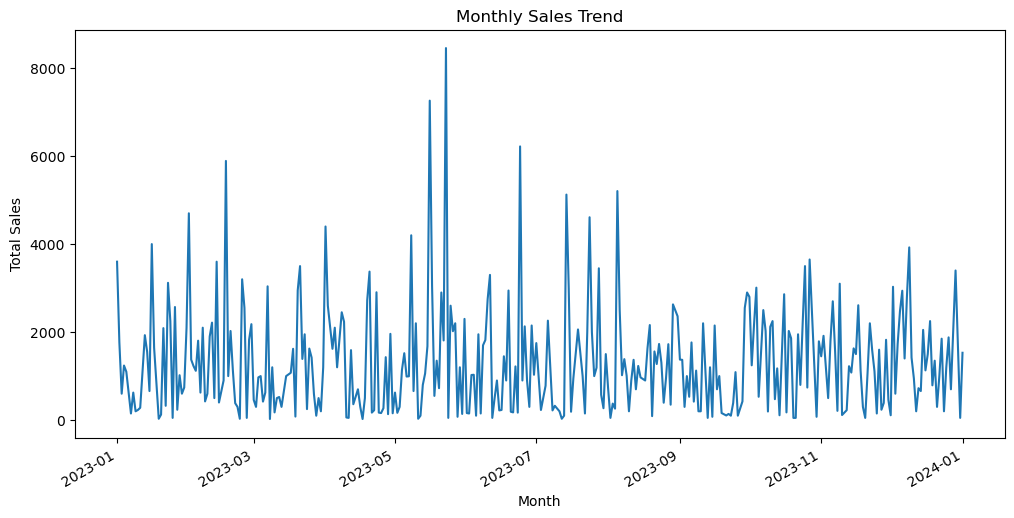

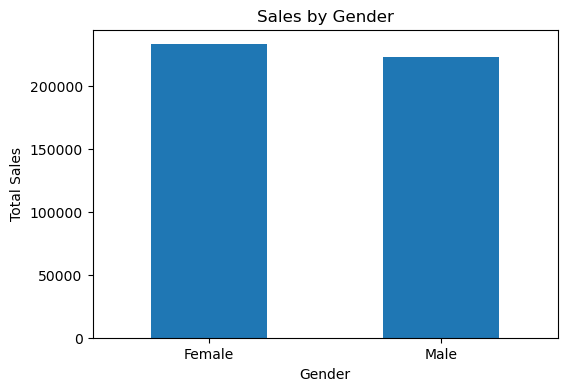

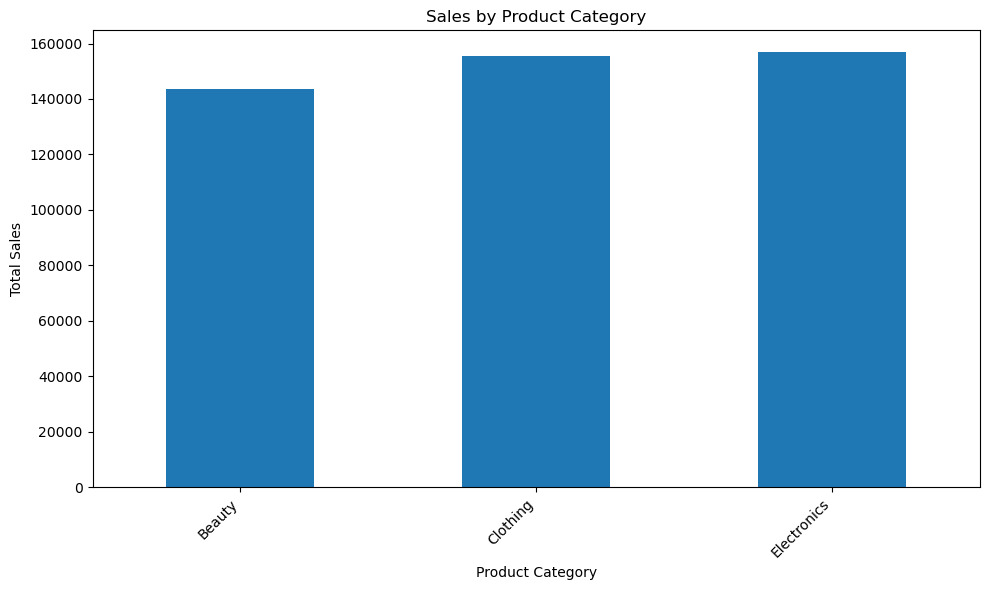

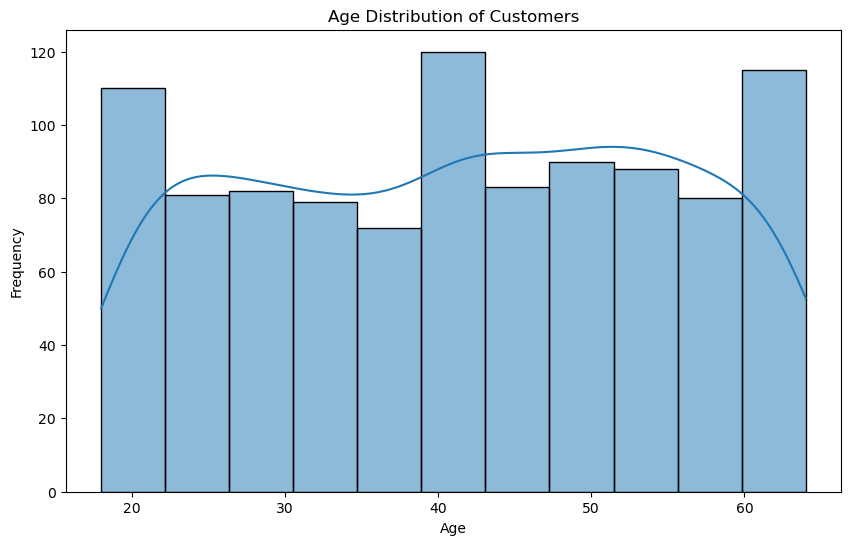

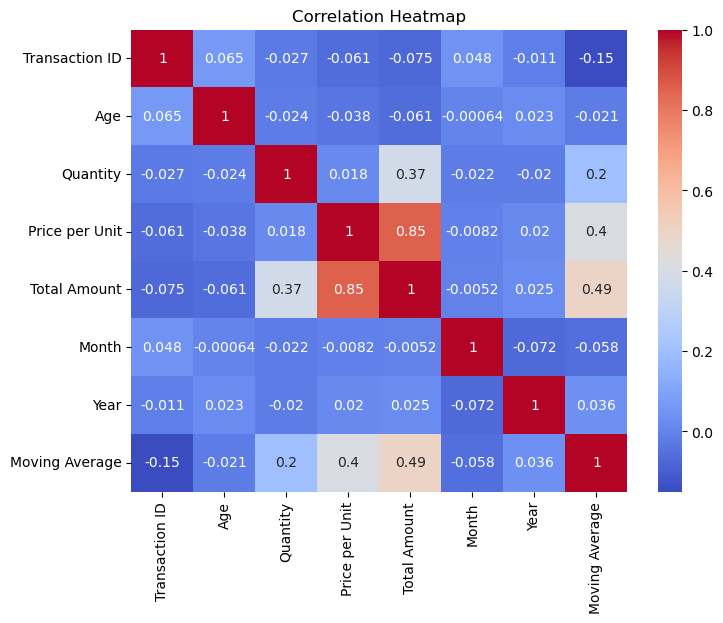

In [21]:
# --- Visualization ---
if not df.empty:  # Check if DataFrame is empty
    # Plot monthly sales
    plt.figure(figsize=(12, 6))
    monthly_sales.plot()
    plt.title('Monthly Sales Trend')
    plt.xlabel('Month')
    plt.ylabel('Total Sales')
    plt.show()

    # Sales by Gender
    plt.figure(figsize=(6, 4))
    gender_sales.plot(kind='bar')
    plt.title('Sales by Gender')
    plt.xlabel('Gender')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=0)
    plt.show()

    # Sales by Product Category
    plt.figure(figsize=(10, 6))
    category_sales.plot(kind='bar')
    plt.title('Sales by Product Category')
    plt.xlabel('Product Category')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Age Distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Age'], kde=True)
    plt.title('Age Distribution of Customers')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.show()

    # Correlation Heatmap - Calculate correlation only on numerical columns
    numerical_df = df.select_dtypes(include=np.number)  # Select only numeric columns
    if not numerical_df.empty:
        plt.figure(figsize=(8, 6))
        sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm')
        plt.title('Correlation Heatmap')
        plt.show()
    else:
        print("No numerical columns available for correlation calculation.")
else:
    print("DataFrame is empty. Cannot create visualizations.")


In [22]:
# --- Recommendations ---
print("\n--- Recommendations ---")

# 1. Focus on High-Value Customers:
print("1. Focus on High-Value Customers: Target customers with RFM scores of 111, 112, and 121 with personalized marketing campaigns and exclusive offers to increase retention and lifetime value.")

# 2. Improve Retention of At-Risk Customers:
print("2. Improve Retention of At-Risk Customers: Implement strategies to re-engage customers with RFM scores of 333 and 444 through targeted promotions and relevant product recommendations.")

# 3. Optimize Product Offerings:
print("3. Optimize Product Offerings: Given that 'Clothing' and 'Electronics' categories have the highest sales, ensure sufficient stock and consider promotions to further drive sales. Investigate underperforming categories to identify potential improvements.")

# 4. Tailor Marketing to Age Groups:
print("4. Tailor Marketing to Age Groups: With a customer base concentrated in the 20-60 age range, customize marketing messages and product offerings to appeal to these demographics. Consider running targeted campaigns for specific age groups.")

# 5. Gender-Based Marketing Strategies:
print("5. Gender-Based Marketing Strategies: Develop gender-specific marketing campaigns to better engage both male and female customers. Highlight products and promotions that cater to each gender's preferences.")



--- Recommendations ---
1. Focus on High-Value Customers: Target customers with RFM scores of 111, 112, and 121 with personalized marketing campaigns and exclusive offers to increase retention and lifetime value.
2. Improve Retention of At-Risk Customers: Implement strategies to re-engage customers with RFM scores of 333 and 444 through targeted promotions and relevant product recommendations.
3. Optimize Product Offerings: Given that 'Clothing' and 'Electronics' categories have the highest sales, ensure sufficient stock and consider promotions to further drive sales. Investigate underperforming categories to identify potential improvements.
4. Tailor Marketing to Age Groups: With a customer base concentrated in the 20-60 age range, customize marketing messages and product offerings to appeal to these demographics. Consider running targeted campaigns for specific age groups.
5. Gender-Based Marketing Strategies: Develop gender-specific marketing campaigns to better engage both male an